## IMAGE CAPTIONING 

### Nipul Agarwal
### Delhi Technological University
### Engineering Physics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip 'drive/My Drive/AI_IMAGE_CAPTION_BOT/Flickr8K_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.optimizers import Adam
import cv2

In [4]:
def readFile(path):
    with open(path) as f:
        captions=f.readlines()
    return captions

In [5]:
captions=readFile('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

In [6]:
### Captions is s list 
### Each element is the list contains the Image id and the corresponding Caption for that Image

In [7]:
len(captions)

40460

In [8]:
first,second=captions[1].split('\t')
print(first.split('.')[0])
print(second)

1000268201_693b08cb0e
A girl going into a wooden building .



In [9]:
### Creating a Dictionary to map every Image with corresponding Captions of that Image
descriptions=dict()
for i in range(len(captions)):
    first,second=captions[i].split('\t')
    img_name=first.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [10]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 'A girl going into a wooden building .\n',
 'A little girl climbing into a wooden playhouse .\n',
 'A little girl climbing the stairs to her playhouse .\n',
 'A little girl in a pink dress going into a wooden cabin .\n']

(500, 375, 3)


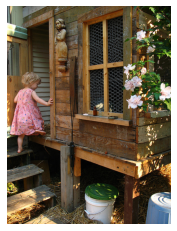

In [11]:
def load_img(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
path='Flickr_Data/Flickr_Data/Images/'+'1000268201_693b08cb0e'+'.jpg'
load_img(path)

#### Data Cleaning
###### Will remove the characters other than alphabets,remove numbers etc.
###### We will not perform stemming and will not remove stopwords because we want our Model to learn a,an the words to form a better english sentence

In [12]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub('[^a-z]+'," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return sentence

In [14]:
### Will Clean all the Captions
for img_id,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i]=clean_text(captions_list[i])

In [15]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
### Writin the data to a text file
with open('descriptions.txt','w') as f:
    f.write(str(descriptions))

#### Creating Vocabulary

##### This  .update will only choose unique words

In [18]:
vocab=set()
for captions in descriptions.values():
    for sentence in captions:
        vocab.update(sentence.split())

In [19]:
len(vocab)

8424

In [20]:
### Count of total words
total_words=[]
for captions in descriptions.values():
    [total_words.append(i) for sentence in captions for i in sentence.split()]

In [21]:
len(total_words)

373837

In [22]:
import collections
counter=collections.Counter(total_words)
frq_cnt=dict(counter)

In [23]:
sorted_frq_cnt=sorted(frq_cnt.items(),reverse=True,key=lambda x:x[1])

In [24]:
sorted_frq_cnt

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [25]:
### Now we will shorten our Vocab for easy computaions of our Model
### Will put a threshold and if a particular word occurs more than that threshold will be in our Vocab
threshold=10
reduced_vocab=[x[0] for x in sorted_frq_cnt if x[1]>threshold]
print(len(reduced_vocab))

1845


In [26]:
reduced_vocab

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

#### Prepare Train/Test Data

In [27]:
train_images_ids=None
test_images_ids=None
with open('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt') as f:
    test_images_ids=f.read()
with open('Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt') as f:
    train_images_ids=f.read()

In [28]:
train_images_ids=train_images_ids.split('\n')[:-1]
test_images_ids=test_images_ids.split('\n')[:-1]

In [29]:
train_images_ids=[img_id.split('.')[0] for img_id in train_images_ids ]
test_images_ids=[img_id.split('.')[0] for img_id in test_images_ids ]

In [30]:
len(train_images_ids)

6000

In [31]:
len(test_images_ids)

1000

#####  Train and test descriptions containing the repective train and test captions 

In [32]:

train_descriptions={}
test_descriptions={}
for img_id in train_images_ids:
    train_descriptions[img_id]=[]
    for caption in descriptions[img_id]:
        cap_to_append='<s> '+caption+' <e>'  ### We will end a <s>,<e> at start and end of 
        train_descriptions[img_id].append(cap_to_append)  ### the sentence so that model while 
for img_id in test_images_ids:              ### training learns when to start and end the sentence
    test_descriptions[img_id]=[]
    for caption in descriptions[img_id]:
        cap_to_append='<s> '+caption+' <e>'
        test_descriptions[img_id].append(cap_to_append)

In [33]:
train_descriptions

{'2513260012_03d33305cf': ['<s> black dog is running after white dog in the snow <e>',
  '<s> black dog chasing brown dog through snow <e>',
  '<s> two dogs chase each other across the snowy ground <e>',
  '<s> two dogs play together in the snow <e>',
  '<s> two dogs running through low lying body of water <e>'],
 '2903617548_d3e38d7f88': ['<s> little baby plays croquet <e>',
  '<s> little girl plays croquet next to truck <e>',
  '<s> the child is playing croquette by the truck <e>',
  '<s> the kid is in front of car with put and ball <e>',
  '<s> the little boy is playing with croquet hammer and ball beside the car <e>'],
 '3338291921_fe7ae0c8f8': ['<s> brown dog in the snow has something hot pink in its mouth <e>',
  '<s> brown dog in the snow holding pink hat <e>',
  '<s> brown dog is holding pink shirt in the snow <e>',
  '<s> dog is carrying something pink in its mouth while walking through the snow <e>',
  '<s> dog with something pink in its mouth is looking forward <e>'],
 '4884

In [34]:
train_descriptions['1000268201_693b08cb0e']

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>']

#### Transfer Learning
###### Step 1- Convert Images to features
###### Step 2- Convert Text to features

###### Image Feature Extraction

In [35]:
model=ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [36]:
model.layers[-2].output  

<tf.Tensor 'avg_pool/Mean:0' shape=(None, 2048) dtype=float32>

In [37]:
model_new=Model(model.input,model.layers[-2].output)

##### We will convert evry image into a (2048,1) vector with the help of ResNet50 Model

In [38]:
def preprocess_image(img_path):
    img=image.load_img(img_path,target_size=[224,224,3])
    img=image.img_to_array(img)
    img=preprocess_input(img)
    img=img.reshape((1,224,224,3))
    #plt.imshow(img)
    return img
def encode_image(img_path):
    #print(img_path)
    img_data=preprocess_image(img_path)
    #print(img_data.shape)
    feature_vector=model_new.predict(img_data)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [39]:
path='Flickr_Data/Flickr_Data/Images/'+'1000268201_693b08cb0e'+'.jpg'
feature_vector=encode_image(path)
print(feature_vector.shape)

(2048,)


In [40]:
### Now we will encode all the training images into a (2048,) vector and store the results into Hard Disk
start_time=time()
Path='Flickr_Data/Images/'
encoded_train={}
for ix,img_id in enumerate(train_images_ids):
    img_path=Path+img_id+'.jpg'
    feature_vector=encode_image(img_path)
    #print(feature_predict.shape)
    encoded_train[img_id]=feature_vector
    
    if(ix%100==0):
        print('Encoding in Progress Completed ',ix,'/6000')
end_time=time()
total_time_taken=end_time-start_time
print('Total Time Taken is ',total_time_taken)

FileNotFoundError: ignored

In [ ]:
### Storing encoded_train_feature for every traininable image in our Hrad Disk from RAM
with open('encoded_train_features.pkl','wb') as f:
    pickle.dump(encoded_train,f)

In [ ]:
len(encoded_train)

6000

In [41]:
encoded_train=None
with open('drive/My Drive/AI_IMAGE_CAPTION_BOT/encoded_train_features.pkl','rb') as f:
    encoded_train=pickle.load(f)

In [42]:
len(encoded_train)

6000

In [ ]:
start_time=time()
Path='Flickr_Data/Images/'
encoded_test={}
for ix,img_id in enumerate(test_images_ids):
    img_path=Path+img_id+'.jpg'
    feature_vector=encode_image(img_path)
    #print(feature_predict.shape)
    encoded_test[img_id]=feature_vector
    
    if(ix%100==0):
        print('Encoding in Progress Completed ',ix,'/1000')
end_time=time()
total_time_taken=end_time-start_time
print('Total Time Taken is ',total_time_taken)

Encoding in Progress Completed  0 /1000
Encoding in Progress Completed  100 /1000
Encoding in Progress Completed  200 /1000
Encoding in Progress Completed  300 /1000
Encoding in Progress Completed  400 /1000
Encoding in Progress Completed  500 /1000
Encoding in Progress Completed  600 /1000
Encoding in Progress Completed  700 /1000
Encoding in Progress Completed  800 /1000
Encoding in Progress Completed  900 /1000
Total Time Taken is  174.65994501113892


In [ ]:
### Storing encoded_test_feature for every traininable image in our Hrad Disk from RAM
with open('encoded_test_features.pkl','wb') as f:
    pickle.dump(encoded_test,f)

NameError: ignored

In [ ]:
len(encoded_test)

In [43]:
encoded_test=None
with open('drive/My Drive/AI_IMAGE_CAPTION_BOT/encoded_test_features.pkl','rb') as f:
    encoded_test=pickle.load(f)

In [44]:
len(encoded_test)

1000

#### Preprocessing Captions

In [45]:
### Vocab
len(reduced_vocab)

1845

In [46]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(reduced_vocab):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [47]:
word_to_idx['dog']

6

In [48]:
idx_to_word[1845]

'cannon'

In [49]:
#### Two Special words that will be added to our vocab are <s> and <e> for starting and ending sequence
idx_to_word[1846]='<s>'
word_to_idx['<s>']=1846

idx_to_word[1847]='<e>'
word_to_idx['<3>']=1847

Vocab_size=len(word_to_idx)
print('Vocab Size: ',Vocab_size)

Vocab Size:  1847


In [50]:
len(word_to_idx)

1847

In [51]:
maxLen=0
for img_id in train_descriptions.keys():
    for caption in train_descriptions[img_id]:
        maxLen=max(maxLen,len(caption.split()))
print(maxLen)

35


#### Custom Data Loader (Generator)

In [83]:
def data_generator(train_descriptions,encoded_train,word_to_idx,maxLen,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        
        for img_id,captions in train_descriptions.items():
            photo=encoded_train[img_id]
            n+=1
            for caption in captions:
                seq=[word_to_idx[word] for word in caption.split() if word in word_to_idx]
            
                for i in range(1,len(seq)):
                
                    xi=seq[:i]
                    yi=seq[i]
                    
                    ### We padd remaining length of the vector with 0
                    xi=pad_sequences([xi],maxlen=maxLen,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=Vocab_size+1)[0]
                    
                    ## This is the one training point
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(x1),np.array(x2)],np.array(y))
                    x1,x2,y=[],[],[]
                    n=0

#### Glove Embeddings

In [84]:
embedding_index={}
with open('drive/My Drive/AI_IMAGE_CAPTION_BOT/glove.6B.50d.txt') as f:
    for line in f.readlines():
        word=line.split()[0]
        word_vec=np.array(line.split()[1:],dtype='float')
        embedding_index[word]=word_vec

In [85]:
### we will look for only those words which are presented in our Vocab and create a required embedding_matrix
def get_embedded_matrix():
    emd_dim=50
    embedding_matrix=np.zeros((Vocab_size+1,emd_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx]=embedding_vector
    return embedding_matrix

In [86]:
embedding_matrix=get_embedded_matrix()

In [87]:
embedding_matrix.shape

(1848, 50)

In [88]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Model Architecture

In [89]:
### Downsampling from 2048 dimesional vector to 256 dimensional vector
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
input_image=Dense(256,activation='relu')(inp_img1)

In [90]:
Vocab_size

1847

In [91]:
#####Captions as Input
input_captions=Input(shape=(maxLen,))
inp1=Embedding(input_dim=Vocab_size+1,output_dim=50,mask_zero=True)(input_captions)
d1=Dropout(0.3)(inp1)
input_caption_output=LSTM(256)(d1)

In [92]:
decoder1=add([input_image,input_caption_output])
decoder2=Dense(256,activation='relu')(decoder1)
output=Dense(Vocab_size+1,activation='softmax')(decoder2)


### Combined Model
model=Model(inputs=[input_img_features,input_captions],outputs=output)


In [93]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_6[0][0]                    
_______________________________________________________________________________________

In [94]:
model.layers[2].set_weights([embedding_matrix])

In [95]:
model.layers[2].trainable=False

In [96]:
adam=Adam(lr=0.001)

In [97]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

#### Training Of a Model

In [98]:
epochs=20
batch_size=3
steps=len(train_descriptions)/batch_size

In [99]:
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoded_train,word_to_idx,maxLen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_'+str(i)+'.h5')

2000/2000 [==============================] - 26s 13ms/step - loss: 2.6689


In [100]:
  for i in range(20,epochs+20):
        generator=data_generator(train_descriptions,encoded_train,word_to_idx,maxLen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_'+str(i)+'.h5')

2000/2000 [==============================] - 26s 13ms/step - loss: 2.5177


In [101]:
  for i in range(40,epochs+40):
        generator=data_generator(train_descriptions,encoded_train,word_to_idx,maxLen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_'+str(i)+'.h5')

2000/2000 [==============================] - 25s 13ms/step - loss: 2.4658


In [102]:
def predict_caption(photo):
    
    in_text='<s>'
    for i in range(maxLen):
        sequence=[word_to_idx[word] for word in in_text.split() if word in word_to_idx.keys()]
        sequence=pad_sequences([sequence],maxlen=maxLen,padding='post')
        
        y_pred=model.predict([photo,sequence])
        y_pred=np.argmax(y_pred)  ### Word with maximum probability always
        word=idx_to_word[y_pred]
        
        in_text+=' '+word
        
        if(word=='<e>'):
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption

In [104]:
for i in range(15):
    no=np.random.randint(0,6000)
    all_img_names=list(encoded_train.keys())
    img_name=all_img_names[no]
    photo_2048=encoded_train[img_name].reshape(1,2048)
    
    img_data=plt.imread('Flickr_Data/Flickr_Data/Images/'+str(img_name)+'.jpg')
    plt.imshow(img_data)
    plt.axis('off')
    plt.show()
    caption=predict_caption(photo_2048)
    print(caption)

Output hidden; open in https://colab.research.google.com to view.